In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable
import torch.cuda as cuda
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from torch.autograd import Variable
from torch.utils.data import TensorDataset

In [2]:
features = np.load('dnnx_exp2.npy',allow_pickle=True)
labels = np.load('y_exp2.npy',allow_pickle=True)

In [3]:
print(features.shape)
print(labels.shape)

(149996, 24)
(149996,)


In [4]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [5]:
encoder = LabelEncoder()
integer_labels = encoder.fit_transform(labels)
labels = integer_labels.reshape(-1)
features = torch.from_numpy(features)
labels = torch.from_numpy(labels)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1111111, random_state=42)
train_set = TensorDataset(X_train,y_train)
val_set = TensorDataset(X_val,y_val)

In [7]:
batch_size = 2048
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=1)
val_loader = DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=1)

In [8]:
 class ANNClassifier(nn.Module):
        def __init__(self,input_size,h1,h2,h3,h4,h5,output_size):
            super(ANNClassifier,self).__init__()
            self.fc1 = nn.Linear(input_size,h1)
            self.relu1 = nn.ReLU()
            self.dropout1 = nn.Dropout(0.25)
            self.fc2 = nn.Linear(h1,h2)
            self.relu2 = nn.ReLU()
            self.dropout2 = nn.Dropout(0.25)
            self.fc3 = nn.Linear(h2,h3)
            self.relu3 = nn.ReLU()
            self.dropout3 = nn.Dropout(0.25)
            self.fc4 = nn.Linear(h3,h4)
            self.relu4 = nn.ReLU()
            self.dropout4 = nn.Dropout(0.25)
            self.fc5 = nn.Linear(h4,h5)
            self.relu5 = nn.ReLU()
            self.dropout5 = nn.Dropout(0.25)
            self.fc6 = nn.Linear(h5,output_size)
            
        def forward(self,x):
            x = self.fc1(x)
            x = self.relu1(x)
            x = self.dropout1(x)
            x = self.fc2(x)
            x = self.relu2(x)
            x = self.dropout2(x)
            x = self.fc3(x)
            x = self.relu3(x)
            x = self.dropout3(x)
            x = self.fc4(x)
            x = self.relu4(x)
            x = self.dropout4(x)
            x = self.fc5(x)
            x = self.relu5(x)
            x = self.dropout5(x)
            x = self.fc6(x)
            return x      

In [9]:
net = ANNClassifier(24,1024,512,256,128,64,3)
net = net.cuda()
criterion = nn.CrossEntropyLoss()
lr = 0.03
optimizer = torch.optim.SGD(net.parameters(),lr=lr)

In [10]:
num_epochs = 500
train_loss=[]
valid_loss=[]
train_accuracy=[]
valid_accuracy=[]

In [11]:
for epoch in range(num_epochs):
    iter_loss = 0.0
    correct = 0
    iterations = 0
    total = 0
    net.train()
    
    for i, (features, labels) in enumerate(train_loader):
        features = Variable(features.float().cuda())
        labels = Variable(labels.long().cuda())
        
        optimizer.zero_grad()
        outputs = net(features)
        loss = F.nll_loss(F.log_softmax(outputs, dim=1), labels)
        
        iter_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        iterations += 1
    
    train_loss.append(iter_loss / iterations)
    train_accuracy.append((100 * correct) / total)
    
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    net.eval()
    
    for i, (feat, lab) in enumerate(val_loader):
        feat = Variable(feat.float().cuda())
        lab = Variable(lab.long().cuda())
        
        out = net(feat)
        loss = F.nll_loss(F.log_softmax(out, dim=1), lab)
        
        val_loss += loss.item()
        _, predicted_val = torch.max(out, 1)
        correct_val += (predicted_val == lab).sum().item()
        total_val += lab.size(0)
    
    valid_loss.append(val_loss / len(val_loader))
    valid_accuracy.append((100 * correct_val) / total_val)
    
    print('epoch %d/%d, trloss: %.4f, tracc: %.4f, valloss: %.4f, valacc: %.4f' % (epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))


epoch 1/500, trloss: 1.0980, tracc: 33.5586, valloss: 1.0920, valacc: 33.0933
epoch 2/500, trloss: 1.0883, tracc: 38.0454, valloss: 1.0777, valacc: 47.7667
epoch 3/500, trloss: 1.0676, tracc: 54.5077, valloss: 1.0380, valacc: 62.4933
epoch 4/500, trloss: 0.9924, tracc: 59.5003, valloss: 0.8924, valacc: 62.5600
epoch 5/500, trloss: 0.8313, tracc: 61.1179, valloss: 0.7496, valacc: 65.9200
epoch 6/500, trloss: 0.7401, tracc: 62.2712, valloss: 0.6901, valacc: 67.8867
epoch 7/500, trloss: 0.6956, tracc: 64.9138, valloss: 0.6460, valacc: 70.8867
epoch 8/500, trloss: 0.6604, tracc: 68.7090, valloss: 0.6027, valacc: 72.5800
epoch 9/500, trloss: 0.6297, tracc: 71.1482, valloss: 0.5842, valacc: 73.3733
epoch 10/500, trloss: 0.6113, tracc: 72.4024, valloss: 0.5699, valacc: 74.0733
epoch 11/500, trloss: 0.5962, tracc: 73.2591, valloss: 0.5528, valacc: 74.6467
epoch 12/500, trloss: 0.5851, tracc: 73.9466, valloss: 0.5450, valacc: 75.1200
epoch 13/500, trloss: 0.5760, tracc: 74.4766, valloss: 0.5399

In [ ]:
torch.save(net.state_dict(), 'annclassifier2.pth')

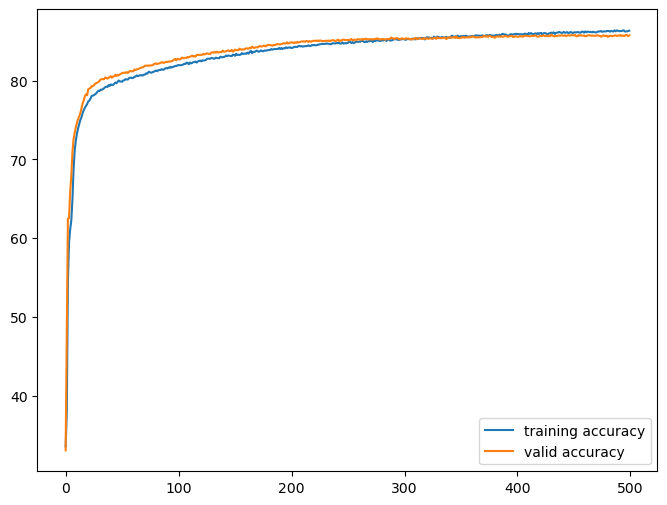

In [12]:
f = plt.figure(figsize=(8,6))
plt.plot(train_accuracy,label='training accuracy')
plt.plot(valid_accuracy,label='valid accuracy')
plt.legend()
plt.show()

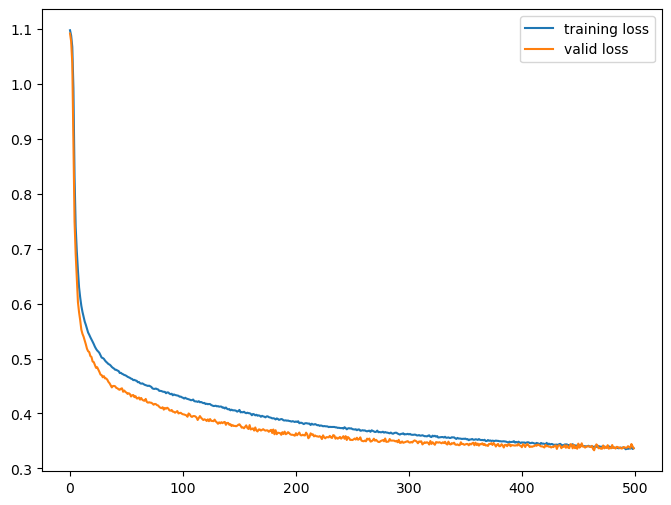

In [13]:
f = plt.figure(figsize=(8,6))
plt.plot(train_loss,label='training loss')
plt.plot(valid_loss,label='valid loss')
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
net.eval()
X_test = X_test.float()
X_test = X_test.cuda()
y_pred = net(X_test)
y_pred = F.softmax(y_pred,dim=1)
y_pred = y_pred.detach().cpu().numpy()
y_pred = np.argmax(y_pred,axis=1)
y_test = y_test.detach().cpu().numpy()
acc = accuracy_score(y_test, y_pred)
pr = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test,y_pred,average='macro')
cm = confusion_matrix(y_pred,y_test)

print('accuracy :',acc)
print('precision :',pr)
print('recall :',rec)
print('f1 score :',f1)


accuracy : 0.861
precision : 0.8617081790060012
recall : 0.8616980179423731
f1 score : 0.8616074611973912


In [15]:
cm

array([[4618,  173,  151],
       [ 207, 4191,  774],
       [  85,  695, 4106]], dtype=int64)

In [16]:
report = classification_report(y_pred,y_test)

In [17]:
print(report)

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      4942
           1       0.83      0.81      0.82      5172
           2       0.82      0.84      0.83      4886

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



In [18]:
del[features,labels]